In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
from src.tree_functions import *
from src.connectivity_functions import *
from src.io_functions import load_data
import os
import json
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20, 10)
import seaborn as sns

In [12]:
project_path = "/workspaces/bha2"
conn_size = 2165

In [13]:
# check if fcm and scm are stored in tmp folder
if os.path.exists(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_fcm.npy")):
    fcm = np.load(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_fcm.npy"))
    scm = np.load(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_scm.npy"))
    print("fcm and scm loaded from tmp folder")
else:
    sc_group = load_data(
        os.path.join(project_path, "data", "raw", "n" + str(conn_size), "sc")
    )
    fc_group = load_data(
        os.path.join(project_path, "data", "raw", "n" + str(conn_size), "fc")
    )
    fcm, scm = connectome_average(fc_group, sc_group)
    os.mkdir(os.path.join(project_path, "tmp"))
    np.save(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_fcm.npy"), fcm)
    np.save(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_scm.npy"), scm)

fcm and scm loaded from tmp folder


In [14]:
zero_rows_sc = np.where(~scm.any(axis=1))[0]
fcm_nonzero, scm_nonzero = remove_rois_from_connectomes(zero_rows_sc, fcm, scm)
density = np.where(scm_nonzero.flatten() > 0, 1, 0).sum(dtype=float) / (
    len(scm_nonzero.flatten())
)
fcm_thr = density_threshold(fcm_nonzero, density)
zero_rows_fc = np.where(~fcm_thr.any(axis=1))[0]
fcm_nonzero, scm_nonzero = remove_rois_from_connectomes(
    zero_rows_fc, fcm_thr, scm_nonzero
)
fcm_bin = np.where(abs(fcm_nonzero) > 0, 1, 0)
scm_bin = np.where(scm_nonzero > 0, 1, 0)

print("connectome density = " + str(density))

connectome density = 0.07191603968863612


Text(0.5, 1.0, 'Structural connectivity matrix')

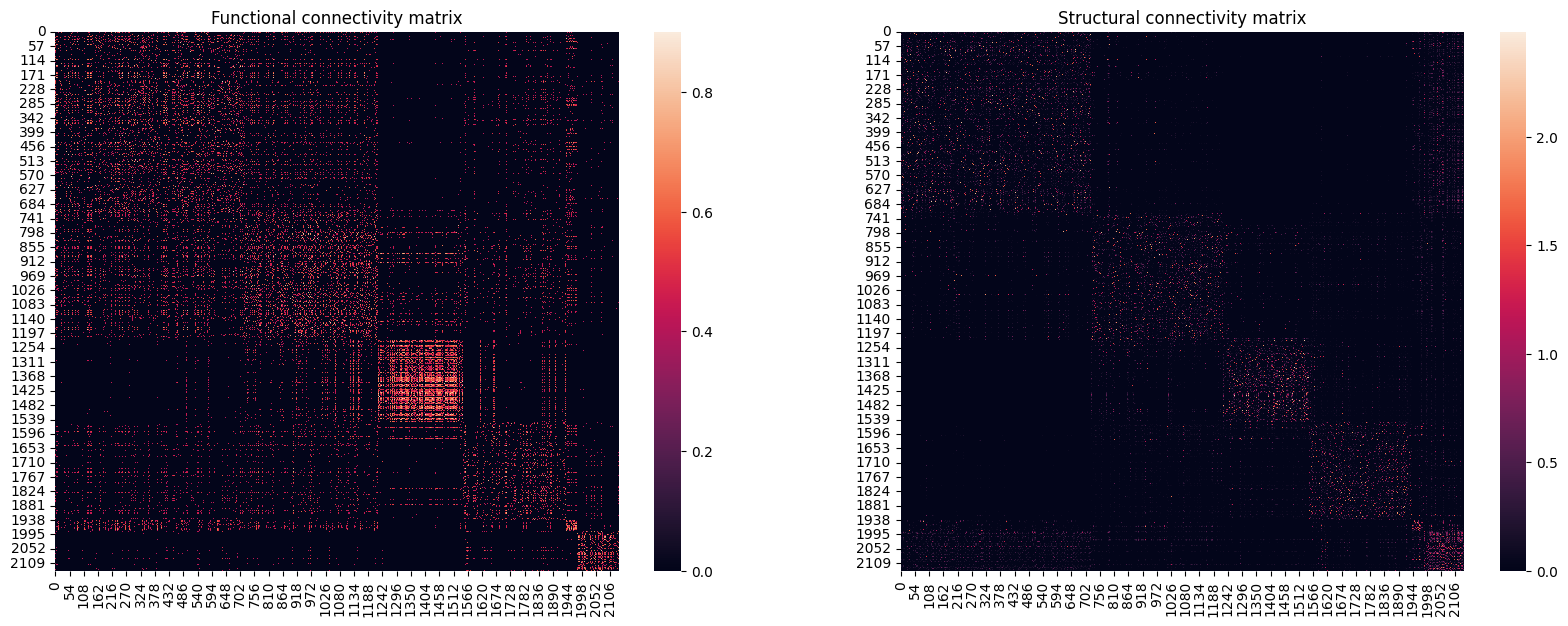

In [15]:
plot, ax = plt.subplots(1, 2, figsize=(20, 7))
sns.heatmap(fcm_nonzero, ax=ax[0])
ax[0].set_title("Functional connectivity matrix")
sns.heatmap(np.log10(scm_nonzero + 1), ax=ax[1])
ax[1].set_title("Structural connectivity matrix")

In [16]:
tree_folder = "tree_network_measures"
tree_min = 2
tree_max = 120
# get the rows with all the elements with zero

for g in np.arange(0, 1.1, 0.1):
    W = matrix_fusion(g, fcm_bin, scm_bin)
    t_dict = tree_dictionary(tree_min, tree_max, W, tree_class="full")
    json.dump(
        t_dict,
        open(
            os.path.join(
                project_path,
                "data",
                "results",
                "n" + str(conn_size),
                "tree_g_" + str(round(g, 2)) + ".json",
            ),
            "w",
        ),
    )

/workspaces/bha2/src/tree_functions.py:11: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(W, "average")
